# KMeans Clustering 클래스 구현

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

In [ ]:
class KMeans:
    def __init__(self, k, tolerance = 1e-04, max_iter = 300):
        self.k = k
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.centroids = None
        self.clusters = None
        self.cluster_labels = None
        self.evaluation = None
        self.iter_num = None

    def fit(self, dataset):

        self.X = np.array(dataset)
        X = self.X

        # k개의 클러스터에 데이터 랜덤 할당
        # 각 데이터에 대해 랜덤한 클러스터 선택
        cluster_labels = np.random.choice(self.k, size=len(X))
        # 각 클러스터에 속하는 데이터들을 저장할 빈 리스트 생성
        clusters = [[] for _ in range(self.k)]

        # 모든 데이터에 대해, 해당하는 클러스터 리스트에 추가
        for i in range(len(X)):
            clusters[cluster_labels[i]].append(X[i])

        # numpy array로 변환
        clusters = [np.array(cluster) for cluster in clusters]

        centroids = self.Centroids(clusters)
        distance_sums = self.Distance_sums(clusters, centroids)
        evaluation = self.Evaluation(distance_sums)

        new_centroids = np.zeros(centroids.shape)
        iter_num = 0
        error = np.ones((self.k, X.shape[1]))

        while np.any(error != self.tolerance) and iter_num < self.max_iter:
            iter_num += 1

            clusters, cluster_labels = self.New_Cluster(X, centroids)
            new_centroids = self.Centroids(clusters)
            error = self.Error(centroids, new_centroids)
            centroids = deepcopy(new_centroids)

            distance_sums = self.Distance_sums(clusters, centroids)
            evaluation = self.Evaluation(distance_sums)

        self.centroids = centroids
        self.clusters = clusters
        self.cluster_labels = cluster_labels
        self.evaluation = evaluation
        self.iter_num = iter_num



    def Centroids(self, clusters):
        centroids = []
        for i, cluster in enumerate(clusters):
            if len(cluster) > 0:
                centroids.append(np.mean(cluster, axis=0))
            else:
                # 빈 클러스터 -> 임의의 데이터 포인트 하나라도 가져오기
                random_idx = np.random.randint(len(self.X))
                centroids.append(self.X[random_idx])  # or np.mean(X, axis=0) 등
        return np.array(centroids)


    def Distance_sums(self, clusters, centroids):
        distance_sums = []
        for i in range(len(clusters)):
            cluster = clusters[i]
            centroid = centroids[i]

            # 추가: 빈 클러스터 예외 처리
            if cluster.size == 0:
                distance_sum = 0  # 데이터가 없으니 거리 합을 0으로.
            elif len(cluster.shape) == 1:
                # cluster가 (d,) 형태 -> 데이터 1개
                distance_sum = np.sqrt(np.sum((cluster - centroid)**2))
            else:
                # cluster가 (n, d) 형태 -> 데이터 n개
                distance_sum = np.sum(
                    np.sqrt(np.sum((cluster - centroid)**2, axis=1))
                )
            distance_sums.append(distance_sum)
        return distance_sums

    def Evaluation(self, distance_sums):
        evaluation = np.sum(distance_sums)
        return evaluation

    def New_Cluster(self, X, centroids):
        cluster_labels = np.zeros(len(X))
        new_clusters = [[] for _ in range(len(centroids))]

        for i, data in enumerate(X):
            distances = [np.sqrt(np.sum((data - centroid)**2)) for centroid in centroids]
            closest_centroid_index = np.argmin(distances)
            new_clusters[closest_centroid_index].append(data)
            cluster_labels[i] = closest_centroid_index

        new_clusters = [np.array(cluster) for cluster in new_clusters]
        return new_clusters, cluster_labels

    def Error(self, centroids, new_centroids):
        k = len(centroids)
        error = np.zeros((k, centroids.shape[1]))

        for i in range(k):
            error[i] = np.sqrt(np.sum((centroids[i] - new_centroids[i])**2))

        return error

  ###################################################################################

    def get_evaluation(self):
        return self.evaluation

    def get_clusters(self):
        return self.clusters

    def get_cluster_labels(self):
        return self.cluster_labels

    def get_centroids(self):
        return self.centroids

    def get_iteration_count(self):
        return self.iter_num


# GA Clustering 구현

1. 랜덤하게 생성된 초기해 군(Population size)으로 시작
- 초기해 생성 시 KMeans로 생성한 해와 랜덤하게 생성한 해를 적절히 구성 가능?
- population_size 설정(KMeans에서 생성된 해를 일정 비율로 넣어보자!)


2. 초기해 평가
- Validation Function: **Intra-cluster distance**


3. Roulette wheel Selection


4. Crossover


5. Mutation
- mutation_prob 설정


6. 해 평가 후 Better Solution으로 업데이트


7. 종료조건까지 step 3 ~ 6 반복
- 종료조건 : max_iteration, early stopping

## Dataset load

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
glass = pd.read_table("G:/내 드라이브/지능형알고리즘/UCI example data/glass.txt", sep=" ")

In [ ]:
X = np.array(glass)
X

array([[ 1.52101, 13.64   ,  4.49   , ...,  8.75   ,  0.     ,  0.     ],
       [ 1.51761, 13.89   ,  3.6    , ...,  7.83   ,  0.     ,  0.     ],
       [ 1.51618, 13.53   ,  3.55   , ...,  7.78   ,  0.     ,  0.     ],
       ...,
       [ 1.52065, 14.36   ,  0.     , ...,  8.44   ,  1.64   ,  0.     ],
       [ 1.51651, 14.38   ,  0.     , ...,  8.48   ,  1.57   ,  0.     ],
       [ 1.51711, 14.23   ,  0.     , ...,  8.62   ,  1.67   ,  0.     ]])

## 1. 초기해 생성
Initialize Population(with KMeans)

In [ ]:
# 랜덤 초기해 생성 함수(with KMeans)
def initialize_population(population_size, k, kmeans_ratio, dataset):    # 초기해 개수, 클러스터 수 데이터셋, kmeans의 해 비율
    population = []
    kmeans_eval = []

    # KMeans를 사용하여 초기 해 생성
    kmeans = KMeans(k)  # max_cluster를 클러스터 수로 사용
    for _ in tqdm(range(int(population_size * kmeans_ratio)), desc=f"Initializing K_means Populations {int(population_size * kmeans_ratio)}\n"):  # population size * kmeans_ratio 해 생성
        kmeans.fit(dataset)
        chromosome = kmeans.cluster_labels.astype(int)
        k_eval = kmeans.evaluation
        num_clusters = np.max(chromosome)  # 각 chromosome에 생성된 클러스터 수 추출
        chromosome = np.append(chromosome, num_clusters)  # 클러스터 수를 chromosome 마지막에 추가 -> 명시하는 용도
        population.append(chromosome)
        kmeans_eval.append(k_eval)

    # 나머지는 랜덤으로 생성
    remaining_size = population_size - len(population)
    X = np.array(dataset)
    for _ in range(remaining_size):
        chromosome = np.random.randint(0, k, size = len(X))  # 랜덤 초기해 생성
        num_clusters = np.max(chromosome)  # 각 chromosome에 생성된 클러스터 수 추출
        chromosome = np.append(chromosome, num_clusters)  # 클러스터 수를 chromosome 마지막에 추가 -> 명시하는 용도
        population.append(chromosome)

    return population

In [ ]:
# 초기해 생성 예시
population_size = 10    # 초기해 10개 설정
k = 6    # 클러스터 개수
kmeans_ratio = 0    # Kmeans의 해를 포함할 비율

initial_population = initialize_population(population_size, k, kmeans_ratio, glass)
for i, chromosome in enumerate(initial_population):
    print(f"Chromosome {i}: {chromosome}")

Initializing K_means Populations 0: 0it [00:00, ?it/s]

Chromosome 0: [0 2 1 1 5 4 5 4 3 5 3 5 4 3 4 5 1 2 3 3 3 1 2 3 5 2 4 1 3 3 1 1 2 0 0 3 1
 5 4 0 5 2 1 1 1 2 2 5 5 0 0 1 5 4 5 2 3 4 1 1 3 5 1 1 2 5 4 0 0 5 4 1 2 1
 0 1 5 5 4 0 4 5 3 4 2 4 5 3 1 5 5 1 2 4 4 2 0 5 5 2 0 5 3 5 5 5 5 4 5 5 2
 3 0 1 1 1 0 3 3 0 1 3 2 0 2 2 2 5 5 5 5 3 5 1 4 5 5 0 1 0 2 0 3 2 4 2 1 4
 5 4 3 5 5 5 2 2 0 1 4 5 4 1 1 5 4 2 4 2 0 0 2 2 4 0 3 0 5 0 3 1 3 2 1 3 0
 5 5 5 5 4 0 5 5 5 1 2 2 5 0 3 4 1 1 0 2 2 1 0 1 1 3 2 5 0 5]
Chromosome 1: [4 0 4 0 3 3 5 1 3 3 3 3 1 4 3 2 4 0 3 3 2 3 0 4 1 3 5 2 2 3 4 0 2 1 2 0 1
 3 4 3 3 3 5 0 5 2 1 4 3 4 5 3 4 3 1 0 3 3 0 4 1 1 2 0 2 3 2 3 2 4 5 1 4 1
 4 1 2 0 5 2 0 5 2 1 5 5 2 4 4 4 5 2 0 3 0 3 3 2 5 4 4 5 0 4 5 4 4 0 1 5 5
 5 5 3 0 4 0 0 4 1 0 2 4 1 2 1 1 2 2 0 0 5 4 1 0 1 5 1 2 3 3 0 1 2 5 2 2 4
 1 0 3 2 4 4 0 0 5 3 1 4 3 0 5 2 0 1 4 3 3 5 5 0 5 1 4 5 5 3 5 4 5 4 4 5 3
 0 3 0 4 5 3 4 5 1 3 1 1 5 5 4 5 1 1 0 5 0 3 5 1 4 3 2 2 3 5]
Chromosome 2: [5 3 3 0 0 2 2 3 5 0 3 4 4 2 5 0 4 0 1 4 0 2 5 2 5 0 0 3 4 2 1 5 2 4 3 5 4
 1 4 1 2 

## 2. 해 평가

In [ ]:
# 해 평가 함수에 필요한 함수 정의

def Centroids(clusters):
    centroids = []
    for cluster in clusters:
        if len(cluster) > 0:
            centroids.append(np.mean(cluster, axis=0))
        else:
            # 빈 클러스터일 경우 임의의 값으로 대체하거나 건너뛸 수 있습니다.
            # 여기서는 NaN으로 설정합니다.
            centroids.append(np.nan)
    return centroids

def Distance_sums(clusters, centroids):
    distance_sums = []

    for i in range(len(clusters)):
        cluster = clusters[i]
        centroid = centroids[i]

        if len(cluster.shape) == 1:
            distance_sum = np.sqrt(np.sum((cluster - centroid)**2))
        else:
            distance_sum = np.sum(np.sqrt(np.sum((cluster - centroid)**2, axis=1)))

        distance_sums.append(distance_sum)

    return distance_sums

def Evaluation(distance_sums):
    evaluation = np.sum(distance_sums)
    return evaluation

def evaluate_solution(clusters):
    return Evaluation(Distance_sums(clusters, Centroids(clusters)))

In [ ]:
# 해 평가(Minimize) 함수
def calculate_evaluation(population, dataset):
  evaluation_list = []
  for i, chromosome in enumerate(population):
    X = np.array(dataset)   # 데이터셋 np.array로 변환

    chromosome_array = chromosome[: -1]   # chromosome array 변환
    num_clusters = int(chromosome[-1]) + 1    # chromosome의 생성된 클러스터 개수

    clusters = [[] for _ in range(num_clusters)]

    for i in range(num_clusters):
      cluster = []    # 각 클러스터의 데이터를 저장할 리스트
      for j, datapoint_cluster in enumerate(chromosome_array):
        if datapoint_cluster == i:    # 데이터 포인트의 클러스터 인덱스에 따라
          cluster.append(X[j])    # 데이터를 저장
      clusters.append(cluster)
    clusters = [np.array(cluster) for cluster in clusters]
    # print(clusters)

    centroids = Centroids(clusters)
    distance_sums = Distance_sums(clusters, centroids)
    evaluation = Evaluation(distance_sums)
    evaluation_list.append(evaluation)
  # print(np.min(evaluation_list))

  return evaluation_list


In [ ]:
# (초기)해 평가 예시
evaluation_list = calculate_evaluation(initial_population, glass)
evaluation_list

[438.2961414115438,
 430.71420140816895,
 439.2894048256602,
 439.73003506294515,
 440.69786608623264,
 434.91388322833916,
 436.73483633378646,
 435.27780770629647,
 429.7305495773688,
 439.4375509759295]

## 3. Roulette Wheel Selection

In [ ]:
# 룰렛 휠 -> 두 개의 부모 해 확률 기반 선택
def roulette_wheel_selection(initial_population, evaluation_list):
  parents_index = []
  parents = []
  total_evaluation = np.sum(evaluation_list)
  # print(f'total_evaluation :{total_evaluation}')

  inv_fit = []
  for eval_i in evaluation_list:
      # 거리합이 0에 가까우면 좋기 때문에, 1 / (1 + eval_i) 등을 사용
      inv_fit.append(1.0 / (1.0 + eval_i))

  sum_fit = sum(inv_fit)
  prob = [x / sum_fit for x in inv_fit]
  # print(f'Fitness: {prob}')

  for _ in range(2):
    # 누적 확률 계산 (누적 분포 함수 생성)
    cumulative_probabilities = np.cumsum(prob)
    # print(f'누적 확률: {cumulative_probabilities}')

    # 랜덤한 확률 값 생성
    random_probability = np.random.rand()
    # print(f'random_value: {random_probability}')

    # 랜덤한 확률 값이 누적 확률에 속하는 개체 선택
    selected_index = np.searchsorted(cumulative_probabilities, random_probability)
    selected_chromosome = initial_population[selected_index]

    parents_index.append(selected_index)
    parents.append(selected_chromosome)

  return parents_index, parents


In [ ]:
# 룰렛 휠 선택 예시 --> 선택된 부모 염색체 2개
selected_index, selected_chromosome = roulette_wheel_selection(initial_population, evaluation_list)
print(selected_index)
selected_chromosome

[4, 1]


[array([5, 4, 0, 3, 2, 4, 3, 0, 3, 3, 3, 0, 2, 5, 3, 2, 4, 3, 3, 4, 0, 4,
        3, 5, 5, 5, 4, 0, 5, 0, 2, 1, 0, 2, 1, 3, 5, 3, 4, 0, 3, 1, 4, 1,
        5, 5, 4, 3, 2, 5, 0, 5, 1, 5, 5, 0, 0, 1, 1, 0, 5, 4, 5, 1, 4, 2,
        1, 0, 2, 1, 4, 1, 3, 5, 4, 4, 3, 3, 5, 2, 5, 2, 5, 2, 5, 3, 2, 4,
        4, 2, 2, 5, 1, 5, 0, 1, 2, 0, 0, 2, 0, 4, 0, 1, 5, 3, 4, 4, 5, 0,
        2, 1, 4, 4, 0, 4, 3, 0, 5, 5, 3, 2, 0, 4, 0, 4, 5, 5, 5, 4, 0, 3,
        2, 4, 4, 1, 1, 4, 1, 0, 0, 1, 5, 4, 2, 5, 1, 0, 4, 3, 1, 2, 2, 3,
        4, 2, 0, 3, 2, 5, 3, 3, 4, 4, 4, 4, 5, 2, 2, 1, 3, 3, 3, 3, 2, 3,
        4, 3, 1, 0, 0, 5, 0, 1, 3, 5, 2, 0, 1, 3, 1, 2, 0, 0, 3, 5, 4, 1,
        4, 1, 1, 1, 4, 0, 0, 5, 2, 0, 1, 3, 2, 5, 4, 5, 5]),
 array([4, 0, 4, 0, 3, 3, 5, 1, 3, 3, 3, 3, 1, 4, 3, 2, 4, 0, 3, 3, 2, 3,
        0, 4, 1, 3, 5, 2, 2, 3, 4, 0, 2, 1, 2, 0, 1, 3, 4, 3, 3, 3, 5, 0,
        5, 2, 1, 4, 3, 4, 5, 3, 4, 3, 1, 0, 3, 3, 0, 4, 1, 1, 2, 0, 2, 3,
        2, 3, 2, 4, 5, 1, 4, 1, 4, 1, 2, 0, 5, 2, 0

## 4. Crossover

In [ ]:
# 선택된 염색체를 평가하는 함수
def evaluate_chromosome(chromosome, dataset):
    """단일 chromosome에 대한 거리합(=목적함수)을 리턴."""
    X = np.array(dataset)

    # chromosome이 [cluster할당..., 마지막엔 실제 클러스터 최대번호]라고 할 때
    chromosome_array = chromosome[:-1]
    num_clusters = int(chromosome[-1])

    clusters = [[] for _ in range(num_clusters + 1)]  # 보통 np.max(chromosome_array)+1 정도
    for idx, c in enumerate(chromosome_array):
        clusters[int(c)].append(X[idx])

    clusters = [np.array(cluster) for cluster in clusters]
    centroids = Centroids(clusters)
    dist_sums = Distance_sums(clusters, centroids)
    return np.sum(dist_sums)

# 교배 함수
def crossover(parents, dataset):
  # new_parents = parents.copy()
  parent_0, parent_1 = parents[0].copy(), parents[1].copy()

  # 부모의 평가값 계산
  parent_eval_0 = evaluate_chromosome(parent_0, dataset)
  parent_eval_1 = evaluate_chromosome(parent_1, dataset)
  # print(f'부모의 평가값: {parent_eval_0}, {parent_eval_1}')

  # 교차점 선택 (임의의 인덱스 선택)
  crossover_point = np.random.randint(1, len(parent_0)-1)
  # print(f'임의의 교차점: {crossover_point}')

  # 두 개의 부모 해를 교차하여 자식 해 생성
  offspring_0 = np.concatenate((parent_0[:crossover_point], parent_1[crossover_point:-1], [parent_0[-1]]))
  offspring_1 = np.concatenate((parent_1[:crossover_point], parent_0[crossover_point:-1], [parent_1[-1]]))

  # 자식의 평가값 계산
  offspring_eval_0 = evaluate_chromosome(offspring_0, dataset)
  offspring_eval_1 = evaluate_chromosome(offspring_1, dataset)
  # print(f'자식의 평가값: {offspring_eval_0}, {offspring_eval_1}')

  # 자식이 부모보다 좋으면 갱신
  new_parents = [parent_0, parent_1]
  if offspring_eval_0 < parent_eval_0:  # Minimize Problem
    new_parents[0] = offspring_0
  if offspring_eval_1 < parent_eval_1:
    new_parents[1] = offspring_1

  return new_parents

In [ ]:
# 교배 예시 --> 교배를 거친 새 염색체 2개
new = crossover(selected_chromosome, glass)
new

[array([5, 4, 0, 3, 2, 4, 3, 0, 3, 3, 3, 0, 2, 5, 3, 2, 4, 3, 3, 4, 0, 4,
        3, 5, 5, 5, 4, 0, 5, 0, 2, 1, 0, 2, 1, 3, 5, 3, 4, 0, 3, 1, 4, 1,
        5, 5, 4, 3, 2, 5, 0, 5, 1, 5, 5, 0, 0, 1, 1, 0, 5, 4, 5, 1, 4, 2,
        1, 0, 2, 1, 4, 1, 3, 5, 4, 4, 3, 3, 5, 2, 5, 2, 5, 2, 5, 3, 2, 4,
        4, 2, 2, 5, 1, 5, 0, 1, 2, 0, 0, 2, 0, 4, 0, 1, 5, 3, 4, 4, 5, 0,
        2, 1, 4, 4, 0, 4, 3, 0, 5, 5, 3, 2, 0, 4, 0, 4, 5, 5, 5, 4, 0, 3,
        2, 4, 4, 1, 1, 4, 2, 3, 3, 0, 1, 2, 5, 2, 2, 4, 1, 0, 3, 2, 4, 4,
        0, 0, 5, 3, 1, 4, 3, 0, 5, 2, 0, 1, 4, 3, 3, 5, 5, 0, 5, 1, 4, 5,
        5, 3, 5, 4, 5, 4, 4, 5, 3, 0, 3, 0, 4, 5, 3, 4, 5, 1, 3, 1, 1, 5,
        5, 4, 5, 1, 1, 0, 5, 0, 3, 5, 1, 4, 3, 2, 2, 3, 5]),
 array([4, 0, 4, 0, 3, 3, 5, 1, 3, 3, 3, 3, 1, 4, 3, 2, 4, 0, 3, 3, 2, 3,
        0, 4, 1, 3, 5, 2, 2, 3, 4, 0, 2, 1, 2, 0, 1, 3, 4, 3, 3, 3, 5, 0,
        5, 2, 1, 4, 3, 4, 5, 3, 4, 3, 1, 0, 3, 3, 0, 4, 1, 1, 2, 0, 2, 3,
        2, 3, 2, 4, 5, 1, 4, 1, 4, 1, 2, 0, 5, 2, 0

In [ ]:
# 이전 부모 염색체와 갱신된 새 염색체 비교 --> 첫번째 염색체는 교배로 갱신(자식 우수), 두번째 염색체는 그대로(부모 우수)
display(initial_population[selected_index[0]])
display(initial_population[selected_index[1]])

initial_population[selected_index[0]] = new[0]
initial_population[selected_index[1]] = new[1]

display(initial_population[selected_index[0]])
display(initial_population[selected_index[1]])

array([5, 4, 0, 3, 2, 4, 3, 0, 3, 3, 3, 0, 2, 5, 3, 2, 4, 3, 3, 4, 0, 4,
       3, 5, 5, 5, 4, 0, 5, 0, 2, 1, 0, 2, 1, 3, 5, 3, 4, 0, 3, 1, 4, 1,
       5, 5, 4, 3, 2, 5, 0, 5, 1, 5, 5, 0, 0, 1, 1, 0, 5, 4, 5, 1, 4, 2,
       1, 0, 2, 1, 4, 1, 3, 5, 4, 4, 3, 3, 5, 2, 5, 2, 5, 2, 5, 3, 2, 4,
       4, 2, 2, 5, 1, 5, 0, 1, 2, 0, 0, 2, 0, 4, 0, 1, 5, 3, 4, 4, 5, 0,
       2, 1, 4, 4, 0, 4, 3, 0, 5, 5, 3, 2, 0, 4, 0, 4, 5, 5, 5, 4, 0, 3,
       2, 4, 4, 1, 1, 4, 1, 0, 0, 1, 5, 4, 2, 5, 1, 0, 4, 3, 1, 2, 2, 3,
       4, 2, 0, 3, 2, 5, 3, 3, 4, 4, 4, 4, 5, 2, 2, 1, 3, 3, 3, 3, 2, 3,
       4, 3, 1, 0, 0, 5, 0, 1, 3, 5, 2, 0, 1, 3, 1, 2, 0, 0, 3, 5, 4, 1,
       4, 1, 1, 1, 4, 0, 0, 5, 2, 0, 1, 3, 2, 5, 4, 5, 5])

array([4, 0, 4, 0, 3, 3, 5, 1, 3, 3, 3, 3, 1, 4, 3, 2, 4, 0, 3, 3, 2, 3,
       0, 4, 1, 3, 5, 2, 2, 3, 4, 0, 2, 1, 2, 0, 1, 3, 4, 3, 3, 3, 5, 0,
       5, 2, 1, 4, 3, 4, 5, 3, 4, 3, 1, 0, 3, 3, 0, 4, 1, 1, 2, 0, 2, 3,
       2, 3, 2, 4, 5, 1, 4, 1, 4, 1, 2, 0, 5, 2, 0, 5, 2, 1, 5, 5, 2, 4,
       4, 4, 5, 2, 0, 3, 0, 3, 3, 2, 5, 4, 4, 5, 0, 4, 5, 4, 4, 0, 1, 5,
       5, 5, 5, 3, 0, 4, 0, 0, 4, 1, 0, 2, 4, 1, 2, 1, 1, 2, 2, 0, 0, 5,
       4, 1, 0, 1, 5, 1, 2, 3, 3, 0, 1, 2, 5, 2, 2, 4, 1, 0, 3, 2, 4, 4,
       0, 0, 5, 3, 1, 4, 3, 0, 5, 2, 0, 1, 4, 3, 3, 5, 5, 0, 5, 1, 4, 5,
       5, 3, 5, 4, 5, 4, 4, 5, 3, 0, 3, 0, 4, 5, 3, 4, 5, 1, 3, 1, 1, 5,
       5, 4, 5, 1, 1, 0, 5, 0, 3, 5, 1, 4, 3, 2, 2, 3, 5])

array([5, 4, 0, 3, 2, 4, 3, 0, 3, 3, 3, 0, 2, 5, 3, 2, 4, 3, 3, 4, 0, 4,
       3, 5, 5, 5, 4, 0, 5, 0, 2, 1, 0, 2, 1, 3, 5, 3, 4, 0, 3, 1, 4, 1,
       5, 5, 4, 3, 2, 5, 0, 5, 1, 5, 5, 0, 0, 1, 1, 0, 5, 4, 5, 1, 4, 2,
       1, 0, 2, 1, 4, 1, 3, 5, 4, 4, 3, 3, 5, 2, 5, 2, 5, 2, 5, 3, 2, 4,
       4, 2, 2, 5, 1, 5, 0, 1, 2, 0, 0, 2, 0, 4, 0, 1, 5, 3, 4, 4, 5, 0,
       2, 1, 4, 4, 0, 4, 3, 0, 5, 5, 3, 2, 0, 4, 0, 4, 5, 5, 5, 4, 0, 3,
       2, 4, 4, 1, 1, 4, 2, 3, 3, 0, 1, 2, 5, 2, 2, 4, 1, 0, 3, 2, 4, 4,
       0, 0, 5, 3, 1, 4, 3, 0, 5, 2, 0, 1, 4, 3, 3, 5, 5, 0, 5, 1, 4, 5,
       5, 3, 5, 4, 5, 4, 4, 5, 3, 0, 3, 0, 4, 5, 3, 4, 5, 1, 3, 1, 1, 5,
       5, 4, 5, 1, 1, 0, 5, 0, 3, 5, 1, 4, 3, 2, 2, 3, 5])

array([4, 0, 4, 0, 3, 3, 5, 1, 3, 3, 3, 3, 1, 4, 3, 2, 4, 0, 3, 3, 2, 3,
       0, 4, 1, 3, 5, 2, 2, 3, 4, 0, 2, 1, 2, 0, 1, 3, 4, 3, 3, 3, 5, 0,
       5, 2, 1, 4, 3, 4, 5, 3, 4, 3, 1, 0, 3, 3, 0, 4, 1, 1, 2, 0, 2, 3,
       2, 3, 2, 4, 5, 1, 4, 1, 4, 1, 2, 0, 5, 2, 0, 5, 2, 1, 5, 5, 2, 4,
       4, 4, 5, 2, 0, 3, 0, 3, 3, 2, 5, 4, 4, 5, 0, 4, 5, 4, 4, 0, 1, 5,
       5, 5, 5, 3, 0, 4, 0, 0, 4, 1, 0, 2, 4, 1, 2, 1, 1, 2, 2, 0, 0, 5,
       4, 1, 0, 1, 5, 1, 2, 3, 3, 0, 1, 2, 5, 2, 2, 4, 1, 0, 3, 2, 4, 4,
       0, 0, 5, 3, 1, 4, 3, 0, 5, 2, 0, 1, 4, 3, 3, 5, 5, 0, 5, 1, 4, 5,
       5, 3, 5, 4, 5, 4, 4, 5, 3, 0, 3, 0, 4, 5, 3, 4, 5, 1, 3, 1, 1, 5,
       5, 4, 5, 1, 1, 0, 5, 0, 3, 5, 1, 4, 3, 2, 2, 3, 5])

## 5. Mutation

In [ ]:
# 돌연변이 함수
def mutation(population, k, mutation_rate = 0.2):
  mutated_population = []

  for chrom in population:
    new_chrom = chrom.copy()
    # 마지막 요소(클러스터 개수)는 건들지 않음
    for j in range(len(chrom)-1):
      # 한 chromosome의 랜덤 확률이 돌연변이율보다 작으면
      if np.random.rand() < mutation_rate:
        current_cluster = new_chrom[j]    # 새 유전자로 변경
        new_cluster = current_cluster

        while new_cluster == current_cluster:
          new_cluster = np.random.randint(0, k)
        new_chrom[j] = new_cluster

    mutated_population.append(new_chrom)

  return mutated_population

In [ ]:
# 돌연변이 예시
B = mutation(initial_population, 6, 0.2)    # 돌연변이율 = 0.2
for i, chromosome in enumerate(B):
    print(f"Chromosome {i}: {chromosome}")

Chromosome 0: [0 2 1 1 5 4 3 4 3 0 3 5 4 4 2 5 1 2 3 3 3 0 2 3 5 2 1 1 3 2 1 1 2 0 0 3 3
 4 4 3 5 2 1 1 1 2 3 5 5 0 0 1 5 4 5 2 3 4 1 1 3 5 1 3 2 5 2 0 0 5 4 1 2 1
 0 1 5 5 4 0 0 5 3 4 3 4 5 0 1 5 5 1 2 3 4 2 0 5 5 4 0 5 3 5 5 5 5 4 5 5 2
 3 0 1 1 1 0 3 3 4 1 3 2 0 2 4 2 5 5 5 3 3 4 1 0 5 4 0 1 0 2 0 3 3 4 2 1 4
 5 4 5 5 5 5 2 2 0 1 4 5 4 3 1 5 4 4 4 2 0 0 2 2 4 0 3 0 2 0 3 1 3 1 1 3 0
 5 5 5 5 4 5 5 5 0 1 2 2 5 0 1 4 4 3 0 3 2 1 1 1 1 3 5 5 0 5]
Chromosome 1: [5 5 4 0 3 1 4 1 3 3 3 3 1 0 3 0 0 0 3 3 2 5 0 4 4 3 1 2 2 3 4 0 2 1 2 0 1
 3 4 3 3 3 3 0 5 2 1 4 3 4 5 3 4 3 4 0 3 3 0 3 1 5 2 0 3 0 2 5 0 4 5 1 4 1
 4 1 2 0 5 2 0 5 2 1 5 5 2 4 1 4 5 5 0 3 0 3 3 3 5 1 4 5 0 4 5 4 4 0 1 5 5
 5 5 3 0 4 0 0 4 1 3 2 0 5 2 1 1 2 2 2 0 5 4 1 0 1 5 0 2 3 3 1 1 4 5 2 2 4
 1 0 3 2 4 4 0 0 0 4 1 4 3 1 5 2 0 4 4 3 3 5 4 0 4 1 4 5 5 3 5 4 5 2 1 5 3
 0 3 0 4 5 3 4 5 1 3 1 1 5 5 4 0 1 1 0 5 0 2 5 1 4 3 2 2 1 5]
Chromosome 2: [5 3 3 4 0 2 2 3 0 4 3 4 4 2 5 0 1 0 1 4 0 2 5 2 5 0 0 3 4 5 0 5 2 4 3 5 4
 1 4 1 2 

# GA Clustering
최종 완성된 GA Clustering 함수(with KMeans)

In [1]:
# 최종 완성된 GA Clustering 함수(with KMeans)
def GA_Clustering(k=5,
                  kmeans_ratio=0,
                  dataset=None,
                  num_generations=500,
                  population_size=300,
                  mutation_rate=0.001,
                  early_stopping_cnt=50):
    """
    k: 군집화할 군집 수
    kmeans_ratio: KMeans 결과 해를 포함할 비율
    dataset: 데이터셋
    num_generations: 세대 수
    population_size: 초기해 개수(반드시 짝수)
    mutation_rate: 돌연변이율
    early_stopping_cnt: early stopping을 위한 연속적으로 개선이 없는 세대 수
    """
    assert population_size % 2 == 0, "population_size must be even"

    best_solution = None
    best_evaluation = float('inf')
    num_gen = 0
    eval_for_plot = []

    # "개선이 없는" 세대가 누적된 횟수
    no_improvement_count = 0

    # 1) 초기해 생성
    population = initialize_population(population_size, k, kmeans_ratio, dataset)

    # 2) 초기해 평가
    evaluation_list = calculate_evaluation(population, dataset)
    best_solution = population[np.argmin(evaluation_list)]
    best_evaluation = np.min(evaluation_list)
    eval_for_plot.append(best_evaluation)

    print(f"Generation {num_gen}, best_eval={best_evaluation}")

    # 3) 세대 반복
    while num_gen < num_generations:
        # 부모 선택 & 교배로 새 자식들 생성 - 초기해 개수만큼 생성될 때까지 반복
        new_population = []

        for _ in range(population_size // 2):
            parents_index, parents = roulette_wheel_selection(population, evaluation_list)
            offspring = crossover(parents, dataset)  # offspring[0], offspring[1]
            new_population.extend(offspring)

        # 돌연변이
        mutated_population = mutation(new_population, k, mutation_rate)
        population = mutated_population

        # 평가
        evaluation_list = calculate_evaluation(population, dataset)
        local_best_evaluation = np.min(evaluation_list)

        # 베스트 갱신 여부 확인
        if local_best_evaluation < best_evaluation:
            best_evaluation = local_best_evaluation
            best_solution = population[np.argmin(evaluation_list)]
            no_improvement_count = 0    # 개선이 있으면 0으로 리셋
        else:
            no_improvement_count += 1   # 개선이 없으면 +1 count

        eval_for_plot.append(local_best_evaluation)

        num_gen += 1
        # print(f"Generation {num_gen}, best_eval={best_evaluation}")

        # **개선이 없는 세대가 일정 횟수 이상이면 조기 종료**
        if no_improvement_count >= early_stopping_cnt:
            print(f"No improvement for {early_stopping_cnt} consecutive generations. Stopping early.")
            break

    # 4) 학습 과정 시각화
    plt.plot(range(len(eval_for_plot)), eval_for_plot, marker='o', linestyle='-')
    plt.title('Evaluation over generation (Stop when no improvement)')
    plt.xlabel('Generation')
    plt.ylabel('Evaluation')
    plt.grid(True)
    plt.show()

    return best_solution, best_evaluation, eval_for_plot

Generation 0, best_eval=428.7478357717046
Generation 1, best_eval=428.6789784561496
Generation 2, best_eval=426.47498320969066
Generation 3, best_eval=422.77779496357994
Generation 4, best_eval=420.76358558421435
Generation 5, best_eval=420.6165223134015
Generation 6, best_eval=420.6165223134015
Generation 7, best_eval=418.90931704921246
Generation 8, best_eval=418.6624709910068
Generation 9, best_eval=414.9123591981788
Generation 10, best_eval=414.9123591981788
Generation 11, best_eval=414.9123591981788
Generation 12, best_eval=414.9123591981788
Generation 13, best_eval=414.6402547841762
Generation 14, best_eval=414.6402547841762
Generation 15, best_eval=414.6402547841762
Generation 16, best_eval=414.6402547841762
Generation 17, best_eval=414.10047056430807
Generation 18, best_eval=411.23546573691056
Generation 19, best_eval=411.23546573691056
Generation 20, best_eval=411.23546573691056
Generation 21, best_eval=410.6013735726517
Generation 22, best_eval=407.36201976414054
Generation 2

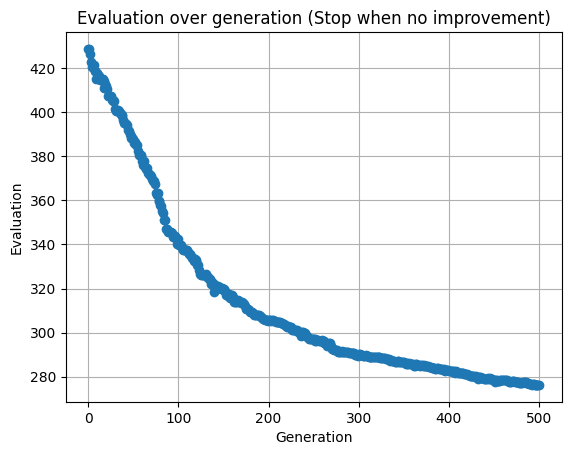

In [ ]:
# Glass 데이터셋 GA Clustering 예시
best_solution, best_evaluation, eval_for_plot = GA_Clustering(k = 6, kmeans_ratio = 0, dataset=glass,
                                                               num_generations = 500, population_size = 300, mutation_rate = 0.001,
                                                               early_stopping_cnt=50)

# 실험
- Iris Dataset
- Wine Dataset
- Glass Dataset
- Vowel Dataset
- Cloud Dataset

## Iris Dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
iris = pd.read_table("G:/내 드라이브/지능형알고리즘/UCI example data/iris.txt", sep=" ")

Generation 0, best_eval=274.5386192026946
Generation 1, best_eval=274.5386192026946
Generation 2, best_eval=274.5386192026946
Generation 3, best_eval=274.5386192026946
Generation 4, best_eval=271.82514567170443
Generation 5, best_eval=271.82514567170443
Generation 6, best_eval=270.76142081086005
Generation 7, best_eval=268.6809072717605
Generation 8, best_eval=268.6809072717605
Generation 9, best_eval=266.2231079352536
Generation 10, best_eval=264.4133181817113
Generation 11, best_eval=263.7093910128736
Generation 12, best_eval=263.4143243007362
Generation 13, best_eval=260.87357328217723
Generation 14, best_eval=260.1910707587645
Generation 15, best_eval=256.917045777045
Generation 16, best_eval=248.2325514473141
Generation 17, best_eval=248.2325514473141
Generation 18, best_eval=248.2325514473141
Generation 19, best_eval=248.2325514473141
Generation 20, best_eval=248.2325514473141
Generation 21, best_eval=248.2325514473141
Generation 22, best_eval=244.92583208506312
Generation 23, be

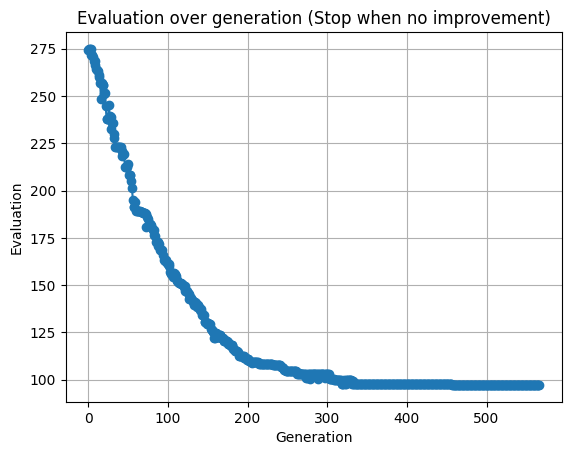

Final Evaluation: 97.2221276510077
Best Clusters : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1 2]


In [ ]:
k = 3
kmeans_ratio = 0
dataset = iris
num_generations = 1000
population_size = 300
mutation_rate = 0.001
early_stopping_cnt=50
best_solution, best_evaluation, eval_for_plot = GA_Clustering(k = k, kmeans_ratio = kmeans_ratio, dataset=dataset,
                                                               num_generations = num_generations, population_size = population_size, mutation_rate = mutation_rate,
                                                               early_stopping_cnt=early_stopping_cnt)

# print("Final Clusters:")
# print(clusters)
print("Final Evaluation:", best_evaluation)
print(f'Best Clusters : {best_solution}')

## Wine Dataset

In [ ]:
wine = pd.read_table("G:/내 드라이브/지능형알고리즘/UCI example data/wine.txt", sep=" ")

Generation 0, best_eval=43491.46055765809
Generation 1, best_eval=43491.46055765809
Generation 2, best_eval=43491.46055765809
Generation 3, best_eval=43491.46055765809
Generation 4, best_eval=43491.46055765809
Generation 5, best_eval=43491.46055765809
Generation 6, best_eval=43491.46055765809
Generation 7, best_eval=42975.86201309132
Generation 8, best_eval=42975.86201309132
Generation 9, best_eval=42746.345421701255
Generation 10, best_eval=42483.36258816034
Generation 11, best_eval=42483.36258816034
Generation 12, best_eval=42483.36258816034
Generation 13, best_eval=42274.37340230644
Generation 14, best_eval=42274.37340230644
Generation 15, best_eval=41756.714518998226
Generation 16, best_eval=41388.29849422838
Generation 17, best_eval=41388.29849422838
Generation 18, best_eval=41388.29849422838
Generation 19, best_eval=41388.29849422838
Generation 20, best_eval=41388.29849422838
Generation 21, best_eval=40685.76031761315
Generation 22, best_eval=40021.67804346416
Generation 23, best

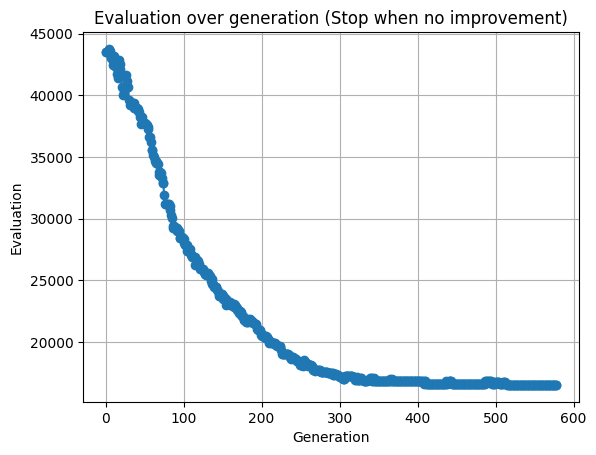

Final Evaluation: 16510.196677408763
Best Clusters : [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0
 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 0 2 2 0 2 2 0 0 0 2 2 1
 0 2 2 2 0 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 1 0 2 0 2 0 2 2 2 0 2 2 2 2 0 2
 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 0 0 0 0 2 2 0 0 0 2 2 0 0 2 0
 0 2 2 2 2 0 0 0 2 0 0 0 2 0 2 0 0 2 0 0 0 0 2 2 0 0 0 0 0 2 2]


In [ ]:
k = 3
kmeans_ratio = 0
dataset = wine
num_generations = 1000
population_size = 300
mutation_rate = 0.001
early_stopping_cnt=50
best_solution, best_evaluation, eval_for_plot = GA_Clustering(k = k, kmeans_ratio = kmeans_ratio, dataset=dataset,
                                                               num_generations = num_generations, population_size = population_size, mutation_rate = mutation_rate,
                                                               early_stopping_cnt=early_stopping_cnt)

# print("Final Clusters:")
# print(clusters)
print("Final Evaluation:", best_evaluation)
print(f'Best Clusters : {best_solution}')

## Glass Dataset

In [ ]:
glass = pd.read_table("/content/drive/MyDrive/지능형알고리즘/UCI example data/glass.txt", sep=" ")

Generation 0, best_eval=429.90157932888604
Generation 1, best_eval=429.1241386215296
Generation 2, best_eval=426.64837709106
Generation 3, best_eval=422.9953868813269
Generation 4, best_eval=422.9953868813269
Generation 5, best_eval=422.9953868813269
Generation 6, best_eval=422.9953868813269
Generation 7, best_eval=422.9953868813269
Generation 8, best_eval=422.9953868813269
Generation 9, best_eval=420.4346213308648
Generation 10, best_eval=420.4346213308648
Generation 11, best_eval=420.0761268203532
Generation 12, best_eval=417.0892042938115
Generation 13, best_eval=417.0892042938115
Generation 14, best_eval=417.0892042938115
Generation 15, best_eval=417.0892042938115
Generation 16, best_eval=413.0970066628593
Generation 17, best_eval=413.0970066628593
Generation 18, best_eval=413.0970066628593
Generation 19, best_eval=413.0970066628593
Generation 20, best_eval=412.6303266551725
Generation 21, best_eval=411.0897677381514
Generation 22, best_eval=411.0897677381514
Generation 23, best_ev

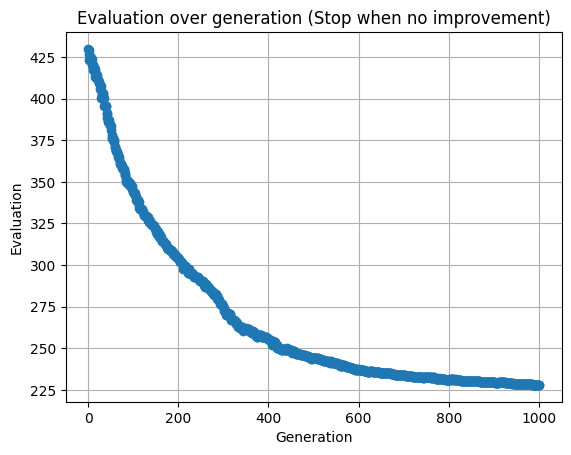

Final Evaluation: 227.95769449656794
Best Clusters : [3 3 3 3 0 1 0 0 2 1 1 1 1 1 3 0 1 2 2 0 1 2 1 1 3 0 3 0 0 0 1 1 0 1 1 3 2
 1 2 2 1 1 1 2 1 2 1 2 2 2 2 3 1 1 1 1 1 1 0 3 3 2 2 2 2 2 2 2 2 2 3 3 0 0
 0 0 3 0 3 0 0 0 3 0 3 3 0 3 0 0 1 0 0 0 0 3 1 1 1 0 1 1 1 2 2 4 4 4 4 4 4
 4 4 3 3 3 3 3 3 3 3 0 0 3 3 3 1 2 2 4 4 4 3 3 3 3 1 0 0 0 3 3 0 0 1 1 3 3
 3 1 3 2 3 3 1 1 3 2 2 2 2 3 2 2 4 4 4 4 4 4 4 5 4 4 2 4 2 2 2 2 5 5 4 4 5
 0 3 3 2 2 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [ ]:
k = 6
kmeans_ratio = 0
dataset = glass
num_generations = 1000
population_size = 300
mutation_rate = 0.001
early_stopping_cnt=50
best_solution, best_evaluation, eval_for_plot = GA_Clustering(k = k, kmeans_ratio = kmeans_ratio, dataset=dataset,
                                                               num_generations = num_generations, population_size = population_size, mutation_rate = mutation_rate,
                                                               early_stopping_cnt=early_stopping_cnt)

# print("Final Clusters:")
# print(clusters)
print("Final Evaluation:", best_evaluation)
print(f'Best Clusters : {best_solution}')


## Vowel Dataset

In [ ]:
vowel = pd.read_table("G:/내 드라이브/지능형알고리즘/UCI example data/vowel.txt", sep=" ")

Generation 0, best_eval=464785.9017264893
Generation 1, best_eval=463970.9967038623
Generation 2, best_eval=462632.14159294794
Generation 3, best_eval=462632.14159294794
Generation 4, best_eval=462566.00526750274
Generation 5, best_eval=462566.00526750274
Generation 6, best_eval=461645.1020867168
Generation 7, best_eval=461645.1020867168
Generation 8, best_eval=461487.39906855114
Generation 9, best_eval=459442.2406417833
Generation 10, best_eval=458988.5419447625
Generation 11, best_eval=458536.52796470415
Generation 12, best_eval=458536.52796470415
Generation 13, best_eval=456132.6786647052
Generation 14, best_eval=456132.6786647052
Generation 15, best_eval=456015.07286926097
Generation 16, best_eval=456015.07286926097
Generation 17, best_eval=456015.07286926097
Generation 18, best_eval=456015.07286926097
Generation 19, best_eval=456015.07286926097
Generation 20, best_eval=456015.07286926097
Generation 21, best_eval=456015.07286926097
Generation 22, best_eval=455427.27706064127
Genera

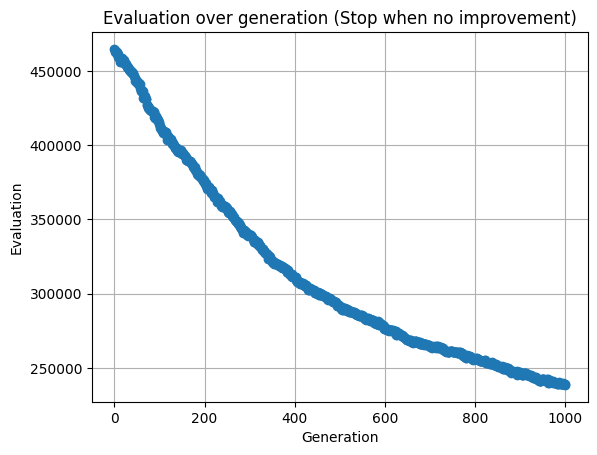

Final Evaluation: 238603.27797095134
Best Clusters : [4 2 1 3 0 0 1 2 0 5 5 2 3 2 5 2 1 1 0 1 4 2 0 0 1 1 0 0 2 2 2 1 2 0 0 0 4
 0 4 3 3 3 0 2 0 4 3 1 5 2 3 1 0 0 3 1 1 4 1 0 0 0 4 3 0 4 4 0 4 5 3 0 4 4
 1 1 2 0 2 4 2 1 1 4 4 1 1 1 0 2 2 2 4 2 1 0 2 4 0 2 4 1 0 0 4 2 2 2 2 4 4
 0 0 0 2 1 0 1 0 1 0 0 2 4 1 1 4 1 0 4 2 0 2 0 2 2 1 0 0 1 0 2 0 1 0 1 1 4
 0 1 1 1 2 4 0 0 2 4 4 0 4 5 5 3 5 5 3 3 5 3 3 3 5 5 5 3 5 3 5 5 5 3 5 5 5
 5 3 3 0 3 3 5 5 3 3 5 2 5 4 3 0 3 1 5 3 0 3 0 5 3 5 5 3 3 3 3 5 5 5 5 5 5
 5 3 5 5 3 3 3 3 5 3 5 5 5 5 5 3 5 0 3 5 3 5 5 3 5 5 5 5 5 5 3 5 3 5 5 3 5
 5 5 5 5 3 3 5 5 5 5 5 3 5 3 5 3 3 5 5 3 5 3 5 5 5 5 5 5 3 3 3 3 5 5 3 5 5
 5 5 3 3 5 5 3 5 5 5 5 5 5 5 3 5 3 5 3 5 3 5 5 5 3 5 5 3 5 3 5 5 5 3 5 5 5
 2 4 1 4 1 0 4 2 4 1 2 0 4 2 1 2 2 2 0 2 2 0 2 4 1 1 4 4 2 2 1 2 2 0 2 1 4
 1 1 4 1 1 2 0 4 2 2 2 1 1 4 1 1 1 1 2 4 1 2 2 1 4 0 1 2 1 2 2 1 1 2 4 1 2
 2 4 1 1 1 2 4 4 1 4 4 4 1 1 1 2 2 4 2 1 0 1 2 2 1 2 2 2 1 4 1 1 1 1 4 1 2
 1 1 4 2 2 1 4 4 1 2 1 2 1 2 2 4 4 2 4 1 4 1 2 

In [ ]:
k = 6
kmeans_ratio = 0
dataset = vowel
num_generations = 1000
population_size = 300
mutation_rate = 0.001
early_stopping_cnt=50
best_solution, best_evaluation, eval_for_plot = GA_Clustering(k = k, kmeans_ratio = kmeans_ratio, dataset=dataset,
                                                               num_generations = num_generations, population_size = population_size, mutation_rate = mutation_rate,
                                                               early_stopping_cnt=early_stopping_cnt)

# print("Final Clusters:")
# print(clusters)
print("Final Evaluation:", best_evaluation)
print(f'Best Clusters : {best_solution}')


## Cloud Dataset

In [ ]:
cloud = pd.read_table("G:/내 드라이브/지능형알고리즘/UCI example data/cloud.txt", sep=" ")

Generation 0, best_eval=389751.70289782766
Generation 1, best_eval=389737.5601542914
Generation 2, best_eval=389609.8226712368
Generation 3, best_eval=388264.2372275535
Generation 4, best_eval=387720.4107040027
Generation 5, best_eval=387238.41527592076
Generation 6, best_eval=387238.41527592076
Generation 7, best_eval=386919.23176503816
Generation 8, best_eval=386919.23176503816
Generation 9, best_eval=386919.23176503816
Generation 10, best_eval=386514.2909495966
Generation 11, best_eval=386326.0250622572
Generation 12, best_eval=386194.5010977416
Generation 13, best_eval=385916.89375762636
Generation 14, best_eval=384398.7567506447
Generation 15, best_eval=384398.7567506447
Generation 16, best_eval=384398.7567506447
Generation 17, best_eval=384398.7567506447
Generation 18, best_eval=384398.7567506447
Generation 19, best_eval=384398.7567506447
Generation 20, best_eval=382519.667329545
Generation 21, best_eval=382258.1082907264
Generation 22, best_eval=382258.1082907264
Generation 23, 

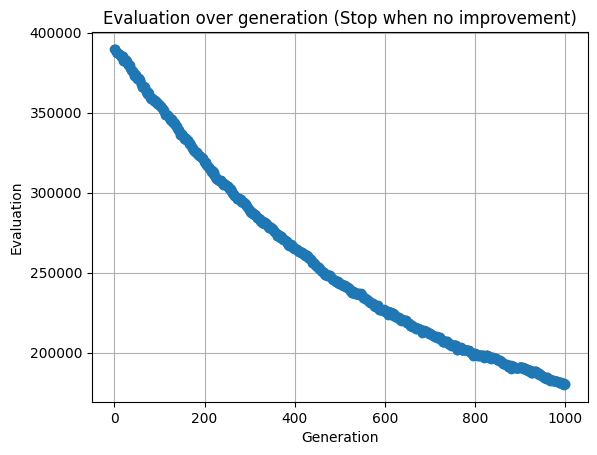

Final Evaluation: 179905.97976336366
Best Clusters : [2 8 6 ... 7 7 9]


In [ ]:
k = 10
kmeans_ratio = 0
dataset = cloud
num_generations = 1000
population_size = 300
mutation_rate = 0.001
early_stopping_cnt=50
best_solution, best_evaluation, eval_for_plot = GA_Clustering(k = k, kmeans_ratio = kmeans_ratio, dataset=dataset,
                                                               num_generations = num_generations, population_size = population_size, mutation_rate = mutation_rate,
                                                               early_stopping_cnt=early_stopping_cnt)

# print("Final Clusters:")
# print(clusters)
print("Final Evaluation:", best_evaluation)
print(f'Best Clusters : {best_solution}')


## Cloud Dataset(kmeans_ratio = 0.9)
K-Means로 나온 해를 초기해에 포함시킴.
- 초기해 개수의 90% 만큼 생성

(가정: 좋은 해를 갖고 시작하면 더 빨리 수렴할 수 있지 않을까..?)

Initializing K_means Populations 90: 100%|██████████| 90/90 [23:44<00:00, 15.82s/it]


Generation 0, best_eval=64042.863022641846
Generation 1, best_eval=64042.863022641846
Generation 2, best_eval=64042.863022641846
Generation 3, best_eval=64042.863022641846
Generation 4, best_eval=64042.863022641846
Generation 5, best_eval=64042.863022641846
Generation 6, best_eval=64042.863022641846
Generation 7, best_eval=64042.863022641846
Generation 8, best_eval=64042.863022641846
Generation 9, best_eval=64042.863022641846
Generation 10, best_eval=64042.863022641846
Generation 11, best_eval=64042.863022641846
Generation 12, best_eval=64042.863022641846
Generation 13, best_eval=64042.863022641846
Generation 14, best_eval=64042.863022641846
Generation 15, best_eval=64042.863022641846
Generation 16, best_eval=64042.863022641846
Generation 17, best_eval=64042.863022641846
Generation 18, best_eval=64042.863022641846
Generation 19, best_eval=64042.863022641846
Generation 20, best_eval=64042.863022641846
Generation 21, best_eval=64042.863022641846
Generation 22, best_eval=64042.86302264184

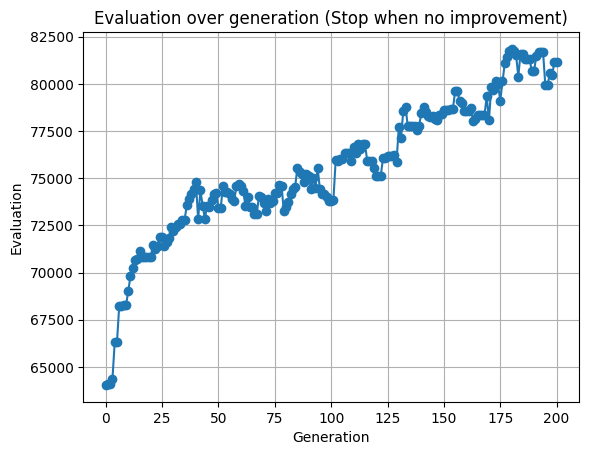

Final Evaluation: 64042.863022641846
Best Clusters : [6 2 4 ... 9 9 9]


In [ ]:
k = 10
kmeans_ratio = 0.9
dataset = cloud
num_generations = 1000
population_size = 100
mutation_rate = 0.001
early_stopping_cnt=200
best_solution, best_evaluation, eval_for_plot = GA_Clustering(k = k, kmeans_ratio = kmeans_ratio, dataset=dataset,
                                                               num_generations = num_generations, population_size = population_size, mutation_rate = mutation_rate,
                                                               early_stopping_cnt=early_stopping_cnt)

# print("Final Clusters:")
# print(clusters)
print("Final Evaluation:", best_evaluation)
print(f'Best Clusters : {best_solution}')


# KMeans 해를 포함한 GA Clustering 결과에 대한 해석

### [실험 전의 나의 생각]: KSA Clustering처럼 KMeans로 나온 좋은 해로 시작하면 더 좋지 않을까?


### [결과]: 더 좋은 해를 찾지 못하고 돌연변이에 의해 안 좋은 해로 나아감


### [결과에 대한 나의 생각]: SA와 GA의 최적해를 찾아가는 방식의 차이점이라고 생각함
- SA - 이웃해를 찾아나가면서 local search를 수행
- GA - local search를 수행하는 과정이 없고, crossover, mutation 과정이 KMeans 해에 일어나면서 더 안 좋은 해로 진행되게 됨.

--> GA에 Local search 기능을 추가한 Hybrid 버전이라면 더 좋은 해를 찾게 될 수 있지 않을까 생각한다.
